In [8]:
import numpy as np

embeddings = np.load("comparison/embeddings_test_lower0.npy") 
# for i in range(1, 5):  # 从 1 开始，避免覆盖初始化的 embeddings
#     embeddings = np.concatenate((embeddings, np.load(f'comparison/embeddings_lower{i}.npy')), axis=0)

labels = np.load("comparison/labels0.npy")
# for i in range(1, 5):
#     labels = np.concatenate((labels, np.load(f'comparison/labels_lower{i}.npy')))


## Supervised model

In [9]:
import torch
import torch.nn as nn

# 重新定義 Classifier 類別
class Classifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  

torch.serialization.add_safe_globals([Classifier])


In [10]:
import torch
import pickle
model = torch.load("classifier_model_lower_test.pth", weights_only=False)

model.eval()  
threshold = 0.4

def predict(model, new_embeddings):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 自動選擇 GPU 或 CPU
    model.to(device)  # 將模型移到對應設備
    new_embeddings = torch.tensor(new_embeddings, dtype=torch.float32).to(device)  # 轉換為 tensor 並移到設備

    with torch.no_grad():  # 禁用梯度計算，加速推理
        outputs = model(new_embeddings)  # 模型輸出 logits
        probabilities = torch.softmax(outputs, dim=1)  # 轉為機率分佈
        
        predictions = torch.argmax(outputs, dim=1)  # 取得預測類別
        max_probs, max_indices = torch.max(probabilities, dim=1)  # 取得最大機率及其對應的類別索引
        predictions = torch.where(max_probs >= threshold, max_indices, torch.tensor(-1, device=outputs.device))


    return predictions.cpu().numpy() 

# 4. **測試新資料**
predictions_supervised = predict(model, new_embeddings=embeddings)


In [11]:
import numpy as np


print("Predicted labels:", predictions_supervised)


Predicted labels: [1 0 2 ... 3 0 3]


In [12]:
np.count_nonzero(predictions_supervised == -1), len(predictions_supervised)

(978, 7528537)

In [13]:
# def get_acc(pred, y_test):
#     return np.sum(y_test == pred) / len(y_test) 

# acc = get_acc(predictions_supervised, labels)

# from sklearn.metrics import precision_score, recall_score, f1_score
# precision = precision_score(labels, predictions_supervised, average='weighted')  # 二分类
# recall = recall_score(labels, predictions_supervised, average='weighted')
# f1 = f1_score(labels, predictions_supervised, average='weighted')

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-score: {f1:.4f}")
# print(f"accuracy: {acc:.4f}")


In [14]:
# import numpy as np

# labels = np.array(labels)  # 轉換為 NumPy 陣列
# mask = labels != -1  # 建立布林遮罩
# filtered_labels = labels[mask]  # 取出不為 -1 的值
# filtered_predicted_supervised = predictions_supervised[mask]

# acc = get_acc(filtered_predicted_supervised, filtered_labels)
# precision = precision_score(filtered_labels, filtered_predicted_supervised, average='weighted')  # 二分类
# recall = recall_score(filtered_labels, filtered_predicted_supervised, average='weighted')
# f1 = f1_score(filtered_labels, filtered_predicted_supervised, average='weighted')

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-score: {f1:.4f}")
# print(f"accuracy: {acc:.4f}")


In [15]:
# import numpy as np

# labels = np.array(labels)  # 轉換為 NumPy 陣列
# mask = labels == -1  # 建立布林遮罩
# filtered_labels = labels[mask]  # 取出不為 -1 的值
# filtered_predicted_supervised = predictions_supervised[mask]

# get_acc(filtered_predicted_supervised, filtered_labels)


## Average model

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


averages = np.load('average_model/average_lower_test.npy')
threshold = 0.95
similarity_matrix = cosine_similarity(embeddings, averages)
max_sim_indices = np.argmax(similarity_matrix, axis=1)
max_sim_values = np.max(similarity_matrix, axis=1)
predicted_averages = np.where(max_sim_values >= threshold, max_sim_indices, -1)
print("Predicted labels:", predicted_averages)

Predicted labels: [1 0 2 ... 3 0 3]


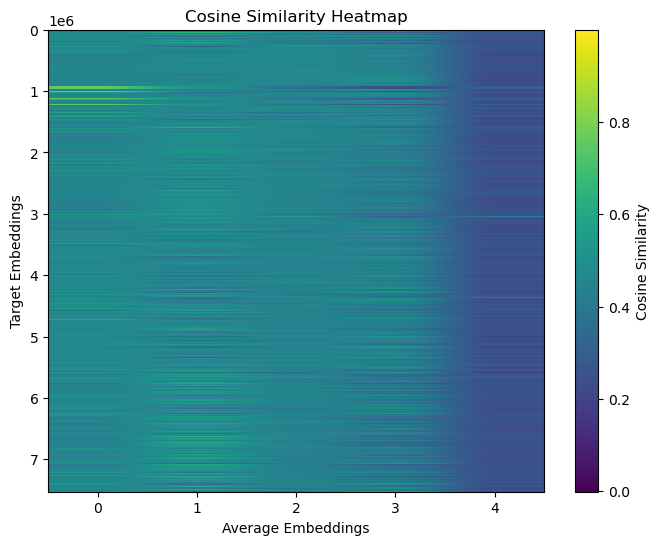

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Average Embeddings')
plt.ylabel('Target Embeddings')
plt.title('Cosine Similarity Heatmap')
plt.show()

In [18]:
np.count_nonzero(predicted_averages == -1), len(predicted_averages)

(537386, 7528537)

In [19]:
# def get_acc(pred, y_test):
#     return np.sum(y_test == pred) / len(y_test) * 100

# acc = get_acc(predicted_averages, labels)

# from sklearn.metrics import precision_score, recall_score, f1_score
# precision = precision_score(labels, predicted_averages, average='weighted')  # 二分类
# recall = recall_score(labels, predicted_averages, average='weighted')
# f1 = f1_score(labels, predicted_averages, average='weighted')

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-score: {f1:.4f}")
# print(f"accuracy: {acc:.4f}")


In [20]:
# import numpy as np

# labels = np.array(labels)  # 轉換為 NumPy 陣列
# mask = labels != -1  # 建立布林遮罩
# filtered_labels = labels[mask]  # 取出不為 -1 的值
# filtered_predicted_avarage = predicted_averages[mask]

# acc = get_acc(filtered_predicted_avarage, filtered_labels)
# precision = precision_score(filtered_labels, filtered_predicted_avarage, average='weighted')  # 二分类
# recall = recall_score(filtered_labels, filtered_predicted_avarage, average='weighted')
# f1 = f1_score(filtered_labels, filtered_predicted_avarage, average='weighted')

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-score: {f1:.4f}")
# print(f"accuracy: {acc:.4f}")


In [21]:
# import numpy as np

# labels = np.array(labels)  # 轉換為 NumPy 陣列
# mask = labels == -1  # 建立布林遮罩
# filtered_labels = labels[mask]  # 取出不為 -1 的值
# filtered_predicted_averages = predicted_averages[mask]

# get_acc(filtered_predicted_averages, filtered_labels)


## save

In [22]:
# with open('Processed_Headings/predictions_supervised7528537-5.pkl', 'wb') as f:
#     pickle.dump(predictions_supervised, f)
# with open('Processed_Headings/predicted_averages7528537-5.pkl', 'wb') as f:
#     pickle.dump(predicted_averages, f)

In [23]:
# with open('Processed_Headings/predictions_supervised7528537.pkl', "rb") as f:
#     data = pickle.load(f).tolist()
# data

In [24]:
# data = []

# with open('Processed_Headings/predictions_supervised7528537.pkl', "rb") as f:
#     data = pickle.load(f).tolist()

# for i in range(2, 6):
#     with open(f'Processed_Headings/predictions_supervised7528537-{i}.pkl', "rb") as f:
#         data = data + pickle.load(f).tolist()

# # 顯示讀取的資料
# with open('Processed_Headings/predictions_supervised.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [25]:
# data = []

# with open('Processed_Headings/predicted_averages7528537.pkl', "rb") as f:
#     data = pickle.load(f).tolist()

# for i in range(2, 6):
#     with open(f'Processed_Headings/predicted_averages7528537-{i}.pkl', "rb") as f:
#         data = data + pickle.load(f).tolist()

# # 顯示讀取的資料
# with open('Processed_Headings/predicted_averages.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [26]:
# with open('Processed_Headings/predicted_averages.pkl', "rb") as f:
#     data = pickle.load(f)
# len(data)

In [27]:
# import pickle
# averaged = []
# with open('Processed_Headings/predicted_averages.pkl', "rb") as f:
#     averaged = pickle.load(f)
# len(averaged)

# supervised = []
# with open('Processed_Headings/predictions_supervised.pkl', "rb") as f:
#     supervised = pickle.load(f)
# len(supervised)

In [35]:
mapping = {
    -1: 'None',
    0:'methods',
    1:'background',
    2:'results',
    3:'conclusions',
    4:'objective',
}

In [ ]:
import pandas as pd

df = pd.read_csv('Processed_Headings/normalized_section_data 2.csv')
df = df.iloc[:7528537]


In [42]:
df['average_prediction'] = [mapping[x] for x in predicted_averages]
df['supervised_prediction'] = [mapping[x] for x in predictions_supervised]
# df.to_csv('Processed_Headings/labeled.csv')
df

,PMCID,PMID,sec-type,sec-title,sec-norm,average_prediction,supervised_prediction
0,PMC5427117,28337662,NaN,Introduction,background,background,background
1,PMC5427117,28337662,NaN,Methods,methods,methods,methods
2,PMC5427117,28337662,NaN,Results,results,results,results
3,PMC5427117,28337662,NaN,Discussion,conclusions,conclusions,conclusions
4,PMC5427117,28337662,NaN,Electronic supplementary material,background,background,background
...,...,...,...,...,...,...,...
7528532,PMC6272716,25749680,NaN,4. Conclusions,NaN,conclusions,conclusions
7528533,PMC6272717,25546619,NaN,1. Introduction,NaN,background,background
7528534,PMC6272717,25546619,NaN,2. Results and Discussion,NaN,conclusions,conclusions
7528535,PMC6272717,25546619,NaN,3. Experimental Section,NaN,methods,methods


In [43]:
df = df[df['sec-norm'].isna()]

df

,PMCID,PMID,sec-type,sec-title,sec-norm,average_prediction,supervised_prediction
11,PMC5496080,28640661,supplementary-material,Supplementary Material,NaN,background,background
12,PMC5496080,28640661,NaN,Disclosure statement,NaN,background,background
13,PMC5496080,28640661,NaN,Ethics and consent,NaN,methods,methods
14,PMC5496080,28640661,NaN,Paper context,NaN,background,background
15,PMC5496080,28640661,supplementary-material,Supplemental data,NaN,background,background
...,...,...,...,...,...,...,...
7528532,PMC6272716,25749680,NaN,4. Conclusions,NaN,conclusions,conclusions
7528533,PMC6272717,25546619,NaN,1. Introduction,NaN,background,background
7528534,PMC6272717,25546619,NaN,2. Results and Discussion,NaN,conclusions,conclusions
7528535,PMC6272717,25546619,NaN,3. Experimental Section,NaN,methods,methods


In [44]:
df.to_csv('Processed_Headings/labeled.csv')

In [1]:
import pandas as pd
df = pd.read_csv('Processed_Headings/labeled.csv')
df = df = df.iloc[:100]
df.to_csv('Processed_Headings/labeled_100.csv')